# Utils

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import glob
from collections import defaultdict

plt.rcParams['figure.figsize'] = [17, 5]

In [9]:
def read_csv(path, substrings=None, max_iters=None):
    
    # Getting a list of relevant filenames
    filenames = glob.glob(path)
    if substrings is not None:
        for substring in substrings:
            filenames = [f for f in filenames if substring in f ]
    # Turning them into dfs, dropping non-numeric columns
    dfs_list = [pd.read_csv(filename, engine='python').select_dtypes(['number']) for filename in filenames]
    # Make sure that all dfs have the same number of trajectories
    if max_iters is not None:
        dfs_list = [df[:max_iters] for df in dfs_list]
    return dfs_list, filenames
    
    
def create_average_df(path, substrings=None, max_iters=None, kpis=None):
    
    dfs_list, filenames = read_csv(path, substrings, max_iters)
    # Adding the filename to each dataframe
    for df, filename in zip(dfs_list, filenames):
      df['Filename'] = filename
    # Combine the list of dataframes, on top of each other
    combo_df = pd.concat(dfs_list, ignore_index=True, sort=False)
    if kpis is None:
        # Set kpis equal to the list of column names except 'Filename'
        kpis = combo_df.columns[:-1]
    n_files = len(filenames)
    means = defaultdict(list)
    for kpi in kpis:
        for it in range(max_iters):
            means[kpi].append(np.array([combo_df[kpi][it + f*max_iters] for f in range(n_files)]).mean())
    df_out = pd.DataFrame.from_dict(means)
    return df_out, filenames, combo_df, dfs_list

def extract_float(s):
    # Extract numbers from garbage string:
    newstr = ''.join((ch if ch in '0123456789.-e' else ' ') for ch in str(s))
    listOfNumbers = [float(i) for i in newstr.split()]
    listOfNumbers = listOfNumbers[0]
    return listOfNumbers

def clean_df(df, str_columns):
    # Transform string columns into floats if there is any 
    fu = lambda x: extract_float(x)
    for column in str_columns:
        df[column] = pd.Series(list(map(extract_float, df[column].astype(str).values)))
    return df

def clean_csv(path, str_columns):
    # Getting a list of relevant filenames
    filenames = glob.glob(path)
    # Turning them into dfs, dropping non-numeric columns
    dfs_list = [pd.read_csv(f) for f in filenames]
    for df, filename in zip(dfs_list, filenames):
        df = clean_df(df, str_columns)
        df.to_csv("{}".format(filename))
    return dfs_list

In [10]:
def plot_data(path, key='ReturnLastEpisode'):
    df = pd.read_csv(path)
    plt.rcParams['figure.figsize'] = [17, 5]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    mean = df[key]
    ax.plot(df['Iteration'], mean)
    return fig

def plot_all(dfs, key='AvgRet', ylim=None, scale='Samples'):
    plt.rcParams['figure.figsize'] = [17, 5]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for df in dfs:
        value = df[key]
        ax.plot(df[scale+'SoFar'], value)
    return fig

def compare_2(means, stds, conf, ylim=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for mean, std in zip(means, stds):
        n_runs = len(mean)
        ax.plot(mean.index, mean)
        interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
        ax.fill_between(mean.index, interval[0], interval[1], alpha=0.3)
    if ylim: ax.set_ylim(ylim)
    ax.legend(bounds)
    return fig

# Calculate, plot and save confidence intervals

def moments(dfs):
    concat_df = pd.concat(dfs, axis=1)
    mean_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).mean()
    std_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).std()
    return mean_df, std_df

def plot_ci(dfs, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration', title=None, grid=True):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    mean = mean_df[key]
    std = std_df[key]
    plt.rcParams['figure.figsize'] = [17, 5]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if isinstance(scale, str):
        ax.plot(mean_df[scale], mean)
    else: # it is possiple to pass a list of ordinates
        ax.plot(scale, mean)
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    if isinstance(scale, str):
         ax.fill_between(mean_df[scale], interval[0], interval[1], alpha=0.3)
    else: # it is possiple to pass a list of ordinates
        ax.fill_between(scale, interval[0], interval[1], alpha=0.3)
   
    if ylim: ax.set_ylim(ylim)
    if title is None:
        title = key
    else:
        title = key + ' - ' + title
    ax.set_title(title)
    if grid: plt.grid()
    return fig

def print_ci(dfs, conf=0.95, key='ReturnLastEpisode'):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    total_horizon = len(mean_df)
    mean = mean_df[key][len(mean_df)-1]
    std = std_df[key][len(mean_df)-1]
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    print('%f \u00B1 %f\t[%f, %f]\t total horizon: %d' % (mean, std, interval[0], interval[1], int(total_horizon)))

def save_ci(dfs, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration', horizon=1000, filename='prova.csv'):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    mean = mean_df[key]
    std = std_df[key]
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    low = pd.Series(interval[0])
    high = pd.Series(interval[1])
    iteration = pd.Series(horizon*np.array(range(len(mean))))
    df_out = pd.DataFrame(list(zip(iteration, mean, std, low, high)), columns=['iteration', 'mean', 'std', 'low', 'up'])
    df_out.to_csv(filename, index=False)


In [11]:
# Clean the datasets from strings which should be floats
# path = "./old_logs/which_dtheta/*"
# str_columns = ['LQGsigma', 'LQGmu01', 'LQGmu1']
# dl = clean_csv(path, str_columns)

In [12]:
def compare(candidates, conf=0.95, key='Regret', ylim=None, xlim=None, scale='Iteration', title=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    entries = []
    for candidate_name in candidates:
        entries.append(candidate_name)
        dfs = candidates[candidate_name]
        n_runs = len(dfs)
        mean_df, std_df = moments(dfs)
        mean = mean_df[key]
        std = std_df[key]
        ax.plot(mean_df[scale], mean)
        interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
        ax.fill_between(mean_df[scale], interval[0], interval[1], alpha=0.3)
        print(candidate_name, end=': ')
        print_ci(dfs, conf)
    ax.legend(entries, loc='upper left')
    if ylim: ax.set_ylim(ylim)
    if xlim: ax.set_xlim(xlim)
    if title is None:
        title = key
    else:
        title = key + ' - ' + title
    ax.set_title(title)
    return fig

# PBPOISE VS UCB1: 50000 iters 100 arms - mu only

ucb1: 16.871513 ± 1.619723	[16.266698, 17.476328]	 total horizon: 5000
pbpoise: 17.290322 ± 0.099131	[17.253306, 17.327338]	 total horizon: 5000
ucb1: 16.871513 ± 1.619723	[16.266698, 17.476328]	 total horizon: 5000
pbpoise: 17.290322 ± 0.099131	[17.253306, 17.327338]	 total horizon: 5000


/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


ucb1: 16.871513 ± 1.619723	[16.266698, 17.476328]	 total horizon: 5000
pbpoise: 17.290322 ± 0.099131	[17.253306, 17.327338]	 total horizon: 5000
ucb1: 16.871513 ± 1.619723	[16.266698, 17.476328]	 total horizon: 5000
pbpoise: 17.290322 ± 0.099131	[17.253306, 17.327338]	 total horizon: 5000


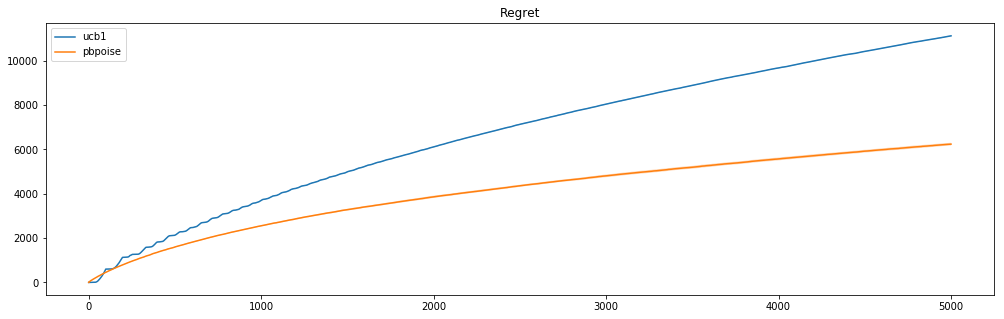

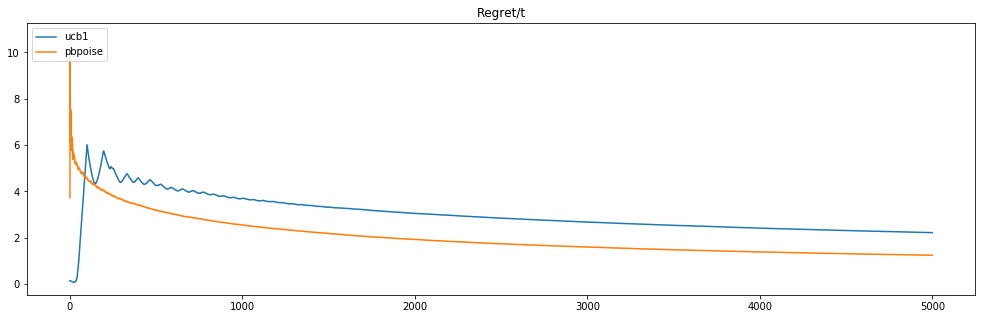

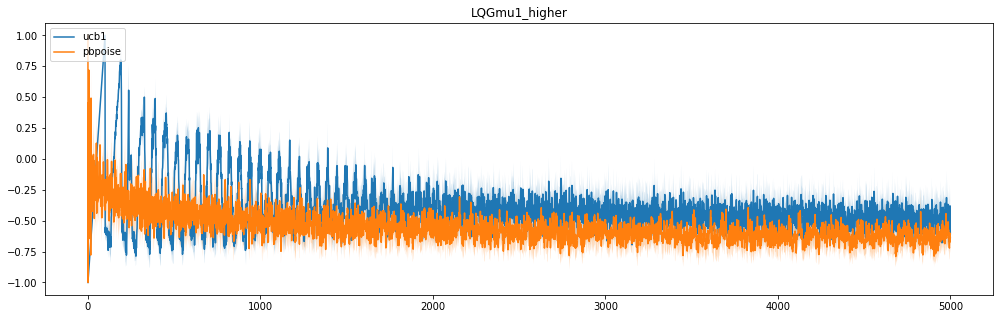

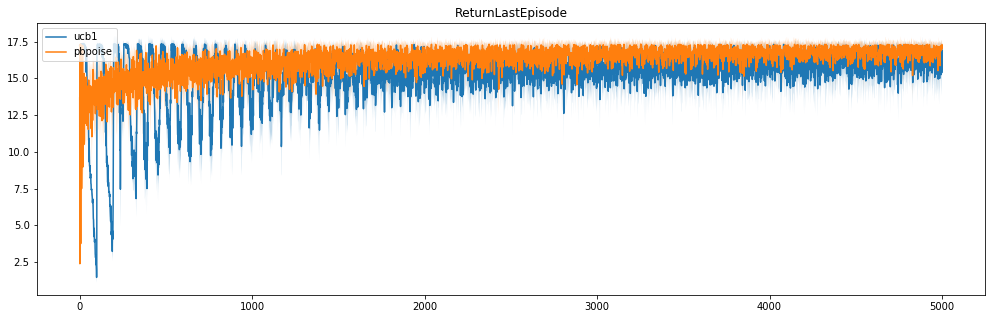

In [42]:
path_ucb1 ="./paper_figures/discrete_setting/mu/ucb1_experiment_5000it_100arms/u*"
path_pbpoise ="./paper_figures/discrete_setting/mu/pbpoise_experiment_5000it_100arms/L*"
dfs_list_ucb1, filenames_ucb1 = read_csv(path_ucb1)
dfs_list_pbpoise, filenames_pbpoise = read_csv(path_pbpoise)
candidates = {'ucb1': dfs_list_ucb1, 'pbpoise': dfs_list_pbpoise}
fig = compare(candidates, conf=0.95, key='Regret', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='Regret/t', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='LQGmu1_higher', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='ReturnLastEpisode', ylim=None, xlim=None, scale='Iteration')

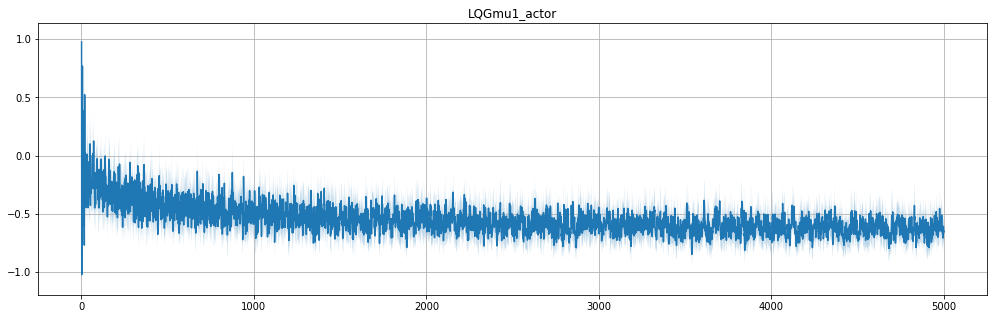

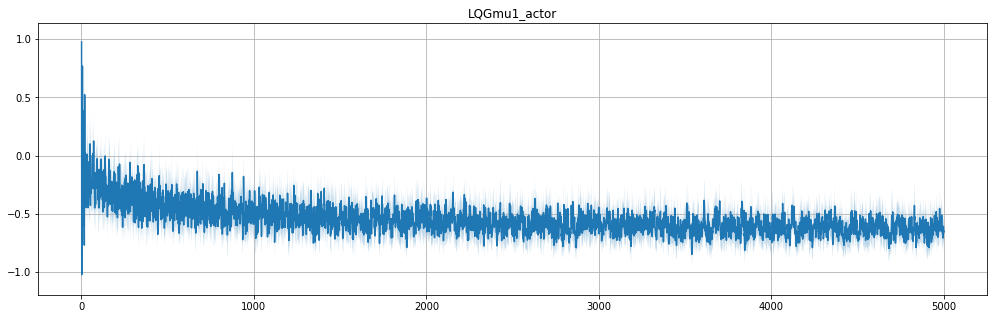

In [41]:
plot_ci(dfs_list_pbpoise, conf=0.95, key='LQGmu1_actor', ylim=None, scale='Iteration', title=None, grid=True)

# PBPOISE VS UCB1: 1000 iters 100 arms - mu only

ucb1: 11.085418 ± 5.188639	[9.147948, 13.022888]	 total horizon: 1000
pbpoise: 16.239840 ± 2.879318	[15.183697, 17.295982]	 total horizon: 999
ucb1: 11.085418 ± 5.188639	[9.147948, 13.022888]	 total horizon: 1000
pbpoise: 16.239840 ± 2.879318	[15.183697, 17.295982]	 total horizon: 999
ucb1: 11.085418 ± 5.188639	[9.147948, 13.022888]	 total horizon: 1000


/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


pbpoise: 16.239840 ± 2.879318	[15.183697, 17.295982]	 total horizon: 999
ucb1: 11.085418 ± 5.188639	[9.147948, 13.022888]	 total horizon: 1000
pbpoise: 16.239840 ± 2.879318	[15.183697, 17.295982]	 total horizon: 999


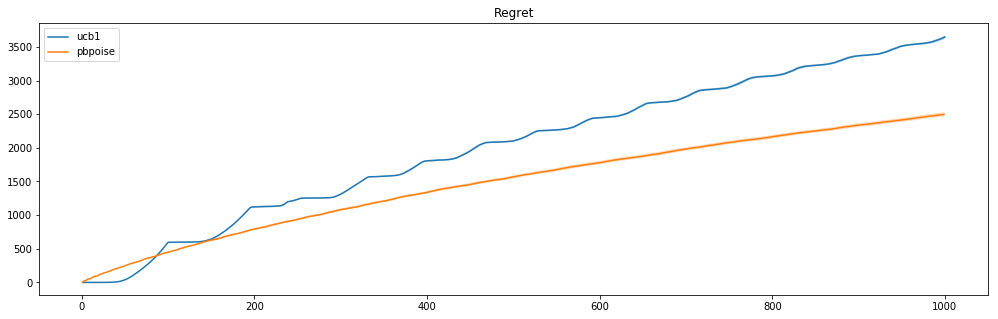

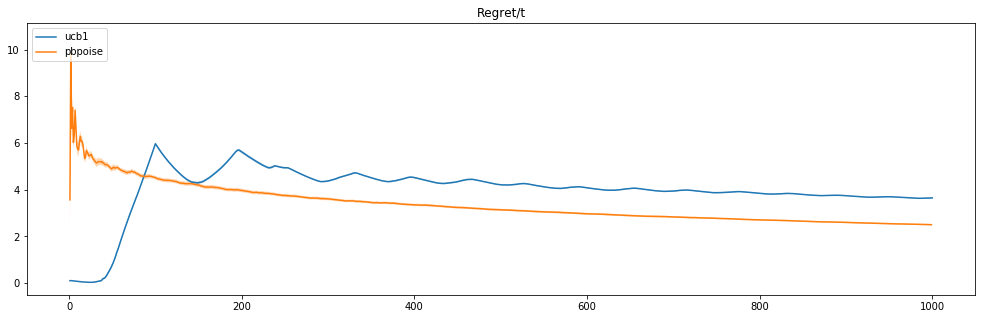

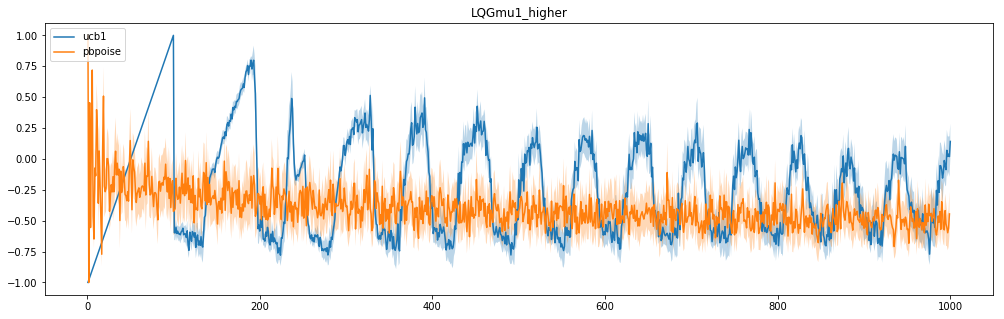

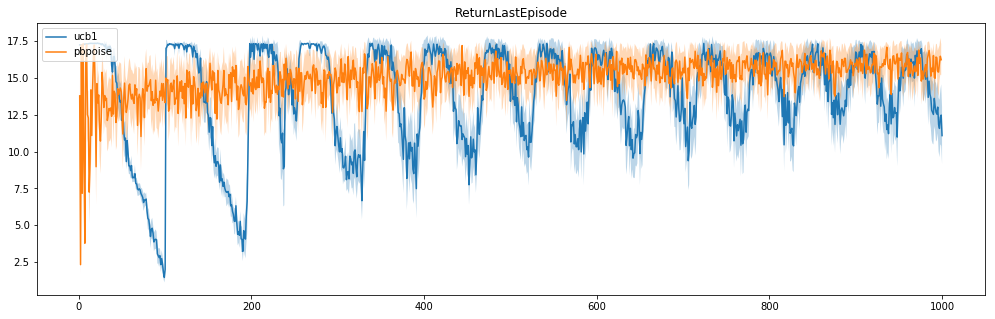

In [29]:
path_ucb1 ="./paper_figures/discrete_setting/mu/ucb1_experiment_1000it_100arms/u*"
path_pbpoise ="./paper_figures/discrete_setting/mu/pbpoise_experiment_1000it_100arms/L*"
dfs_list_ucb1, filenames_ucb1 = read_csv(path_ucb1)
dfs_list_pbpoise, filenames_pbpoise = read_csv(path_pbpoise)
candidates = {'ucb1': dfs_list_ucb1, 'pbpoise': dfs_list_pbpoise}
fig = compare(candidates, conf=0.95, key='Regret', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='Regret/t', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='LQGmu1_higher', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='ReturnLastEpisode', ylim=None, xlim=None, scale='Iteration')

In [101]:
def find_max(dfs_list, key):
    maximum = 0
    for df in dfs_list:
        maximum_i = df['ReturnMax'].max()
        if maximum_i > maximum:
            maximum = maximum_i
    return maximum

In [103]:
path ="/home/lupol/dev/tesi/baselines/baselines/pbpoise/paper_figures/discrete_setting/logs/mu_only_regret_pbpoise/L*"
dfs_list, filenames = read_csv(path)
Rmax = find_max(dfs_list, key='ReturnMax')
print(Rmax)

17.449793


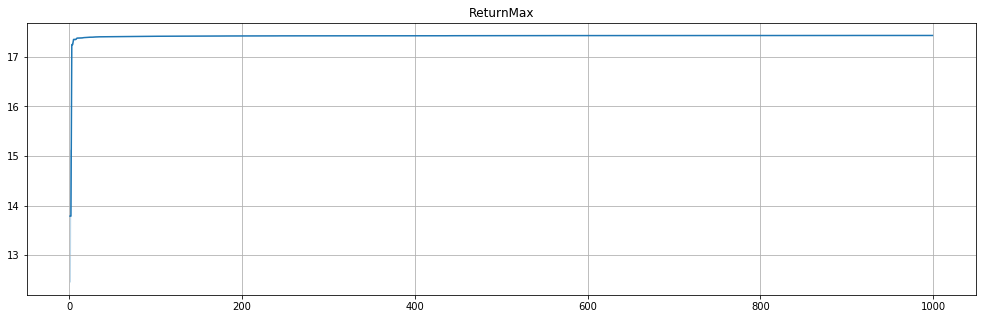

In [95]:
path ="/home/lupol/dev/tesi/baselines/baselines/pbpoise/paper_figures/discrete_setting/logs/mu_only_regret_pbpoise/L*"
dfs_list, filenames = read_csv(path)
fig = plot_ci(dfs_list, conf=0.95, key='ReturnMax', ylim=None, scale="Iteration")

# PBPOISE VS UCB1: 50000 iters 50 arms - mu only

ucb1: 16.609985 ± 2.295379	[15.752876, 17.467093]	 total horizon: 5000
pbpoise: 16.760604 ± 2.128379	[15.965854, 17.555354]	 total horizon: 5000
ucb1: 16.609985 ± 2.295379	[15.752876, 17.467093]	 total horizon: 5000
pbpoise: 16.760604 ± 2.128379	[15.965854, 17.555354]	 total horizon: 5000


/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


ucb1: 16.609985 ± 2.295379	[15.752876, 17.467093]	 total horizon: 5000
pbpoise: 16.760604 ± 2.128379	[15.965854, 17.555354]	 total horizon: 5000
ucb1: 16.609985 ± 2.295379	[15.752876, 17.467093]	 total horizon: 5000
pbpoise: 16.760604 ± 2.128379	[15.965854, 17.555354]	 total horizon: 5000


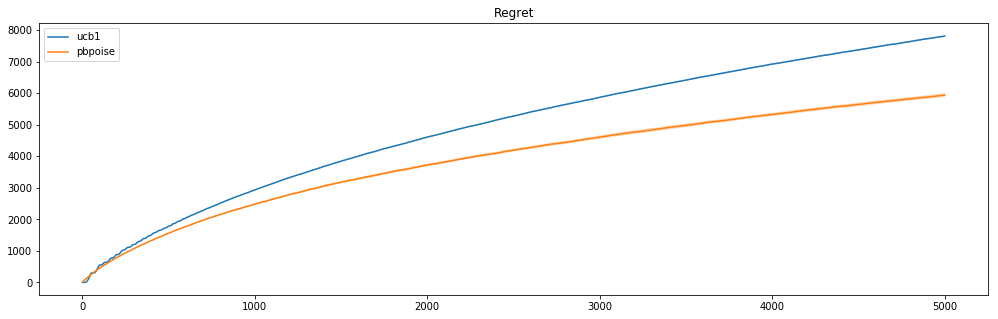

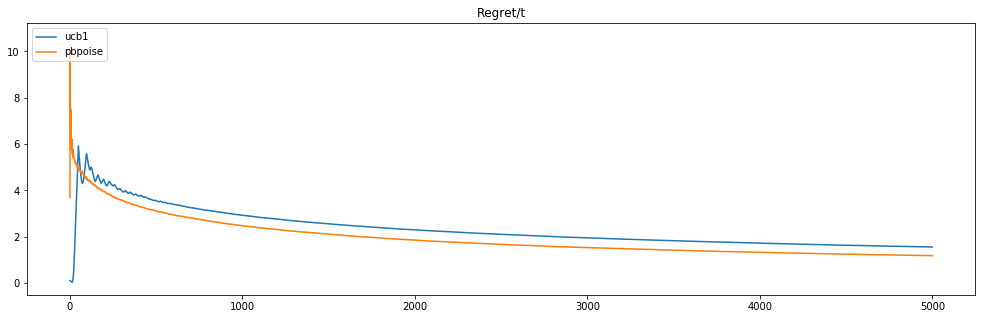

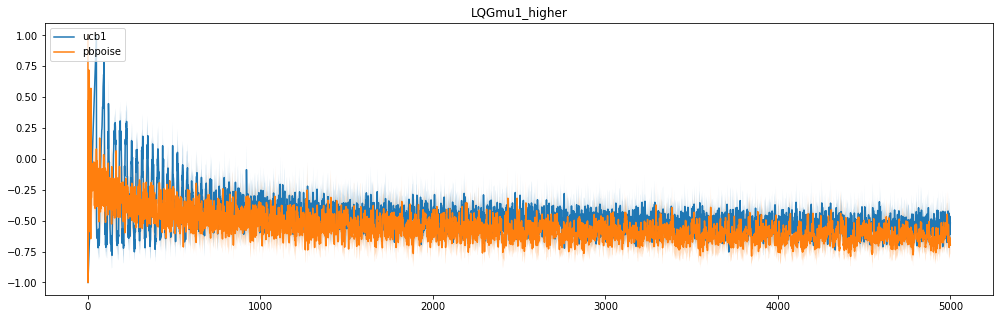

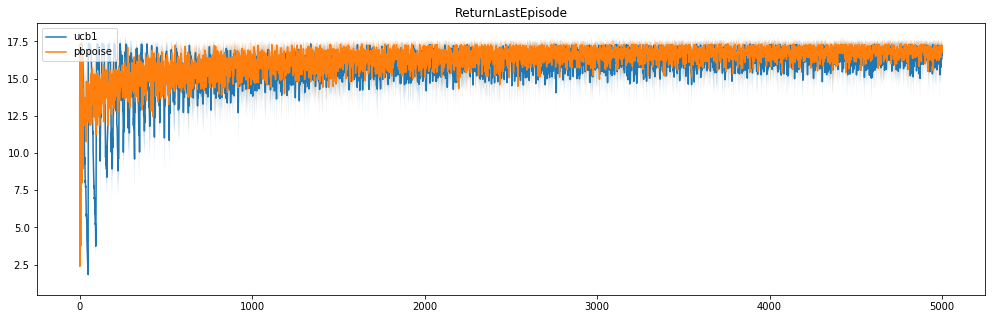

In [27]:
path_ucb1 ="./paper_figures/discrete_setting/mu/ucb1_experiment_5000it_50arms/u*"
path_pbpoise ="./paper_figures/discrete_setting/mu/pbpoise_experiment_5000it_50arms/L*"
dfs_list_pbpoise, filenames_pbpoise = read_csv(path_pbpoise)
candidates = {'ucb1': dfs_list_ucb1, 'pbpoise': dfs_list_pbpoise}
fig = compare(candidates, conf=0.95, key='Regret', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='Regret/t', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='LQGmu1_higher', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='ReturnLastEpisode', ylim=None, xlim=None, scale='Iteration')

# PBPOISE VS UCB1: 30000 iters 50x10 arms - mu&std

ValueError: No objects to concatenate

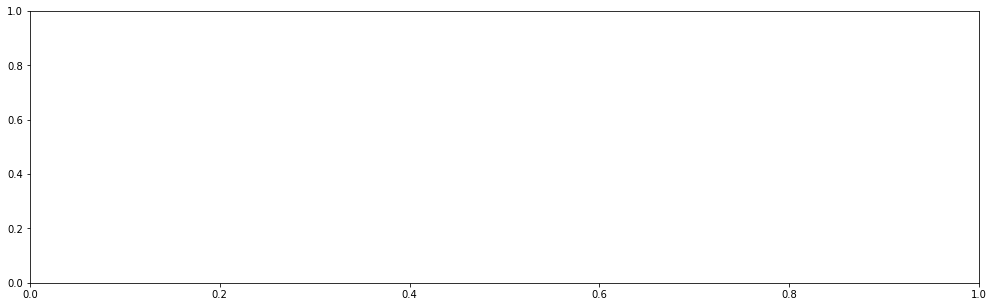

In [49]:
path_ucb1 ="./paper_figures/discrete_setting/mu&std/ucb1_experiment_3000it_50-10arms/u*"
path_pbpoise ="./paper_figures/discrete_setting/mu&std/pbpoise_experiment_3000it_50-10arms/L*"
dfs_list_ucb1, filenames_ucb1 = read_csv(path_ucb1)
dfs_list_pbpoise, filenames_pbpoise = read_csv(path_pbpoise)
candidates = {'ucb1': dfs_list_ucb1, 'pbpoise': dfs_list_pbpoise}
fig = compare(candidates, conf=0.95, key='Regret', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='Regret/t', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='LQGsigma_higher', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='LQGmu1_higher', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='ReturnLastEpisode', ylim=None, xlim=None, scale='Iteration')

# PBPOISE VS UCB1: 30000 iters 50x50 arms - mu&std

ucb1: 15.671042 ± 3.698978	[11.078155, 20.263930]	 total horizon: 3000
pbpoise: 15.405748 ± 3.614463	[10.917799, 19.893697]	 total horizon: 3000
ucb1: 15.671042 ± 3.698978	[11.078155, 20.263930]	 total horizon: 3000
pbpoise: 15.405748 ± 3.614463	[10.917799, 19.893697]	 total horizon: 3000
ucb1: 15.671042 ± 3.698978	[11.078155, 20.263930]	 total horizon: 3000


/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


pbpoise: 15.405748 ± 3.614463	[10.917799, 19.893697]	 total horizon: 3000
ucb1: 15.671042 ± 3.698978	[11.078155, 20.263930]	 total horizon: 3000
pbpoise: 15.405748 ± 3.614463	[10.917799, 19.893697]	 total horizon: 3000


/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1903: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)


ucb1: 15.671042 ± 3.698978	[11.078155, 20.263930]	 total horizon: 3000
pbpoise: 15.405748 ± 3.614463	[10.917799, 19.893697]	 total horizon: 3000


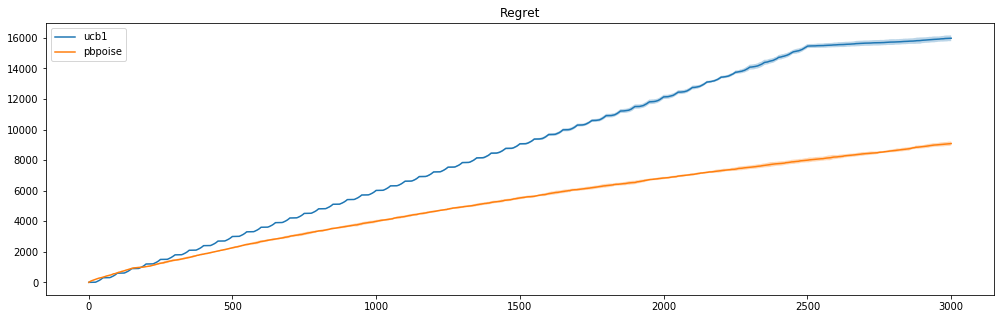

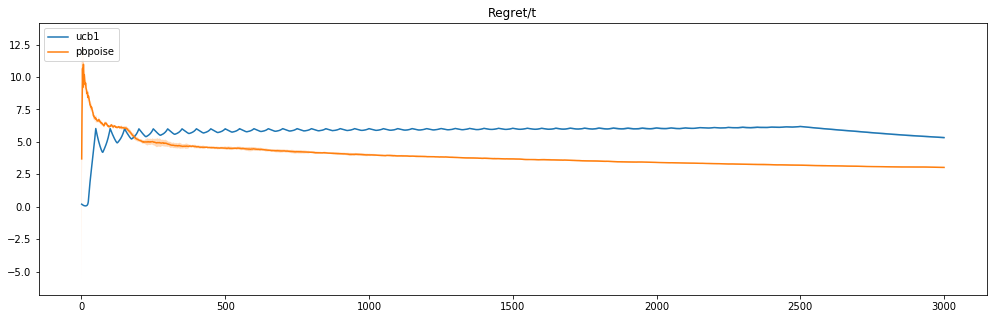

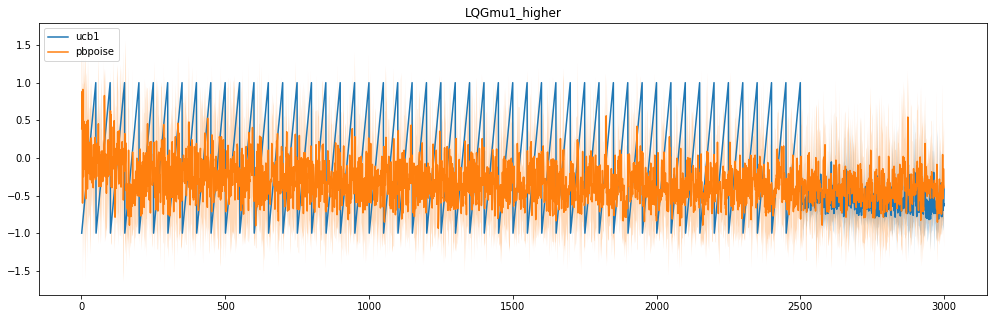

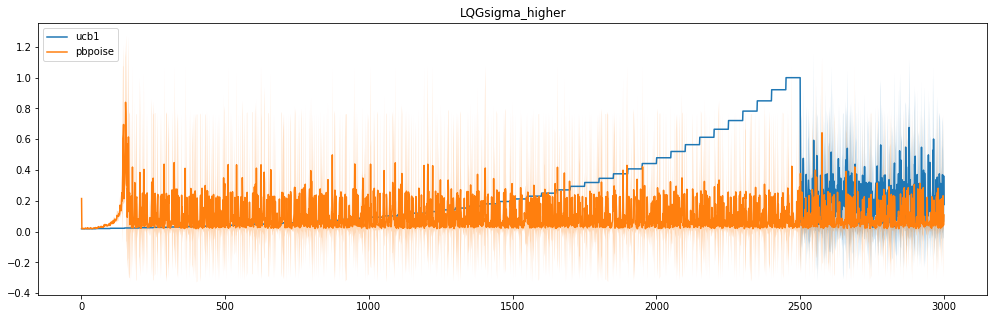

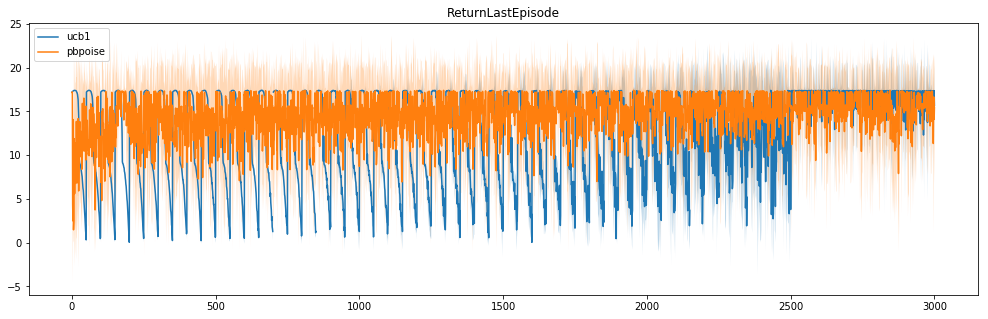

In [47]:
path_ucb1 ="./paper_figures/discrete_setting/mu&std/ucb1_experiment_3000it_50x50arms/u*"
path_pbpoise ="./paper_figures/discrete_setting/mu&std/pbpoise_experiment_3000it_50x50arms/L*"
dfs_list_ucb1, filenames_ucb1 = read_csv(path_ucb1)
dfs_list_pbpoise, filenames_pbpoise = read_csv(path_pbpoise)
candidates = {'ucb1': dfs_list_ucb1, 'pbpoise': dfs_list_pbpoise}
fig = compare(candidates, conf=0.95, key='Regret', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='Regret/t', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='LQGmu1_higher', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='LQGsigma_higher', ylim=None, xlim=None, scale='Iteration')
fig = compare(candidates, conf=0.95, key='ReturnLastEpisode', ylim=None, xlim=None, scale='Iteration')